# DsPy on FIQA Data & Optimize Answer Generation


In [9]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import dspy
import contextlib
from pprint import pprint
from datasets import load_dataset

from deepeval.metrics import GEval
from deepeval.test_case import LLMTestCaseParams, LLMTestCase


import warnings
warnings.filterwarnings('ignore')


model_str = 'gpt-4.1-nano'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load Data Input

* About the Data Source: https://huggingface.co/datasets/explodinggradients/fiqa
  * Only 30 records

In [2]:
fiqa_eval = load_dataset("explodinggradients/fiqa", "ragas_eval")['baseline']

rag_lst = []
for record in fiqa_eval:
    rag_lst.append({
        'question': record['question'],
        'context': record['contexts'],
        'ground_truth': record['ground_truths'][0],
        'answer_before_prompt_opt': record['answer'].strip()
    })

rag_df = pd.DataFrame(rag_lst)
print(rag_df.shape)
rag_df.head()

(30, 4)


,question,context,ground_truth,answer_before_prompt_opt
0,How to deposit a cheque issued to an associate...,[Just have the associate sign the back and the...,Have the check reissued to the proper payee.Ju...,The best way to deposit a cheque issued to an ...
1,Can I send a money order from USPS as a business?,[Sure you can. You can fill in whatever you w...,Sure you can. You can fill in whatever you wa...,"Yes, you can send a money order from USPS as a..."
2,1 EIN doing business under multiple business n...,[You're confusing a lot of things here. Compan...,You're confusing a lot of things here. Company...,"Yes, it is possible to have one EIN doing busi..."
3,Applying for and receiving business credit,[Set up a meeting with the bank that handles y...,"""I'm afraid the great myth of limited liabilit...",Applying for and receiving business credit can...
4,401k Transfer After Business Closure,[The time horizon for your 401K/IRA is essenti...,You should probably consult an attorney. Howev...,If your employer has closed and you need to tr...


In [ ]:
# the trainset, devset for DsPy
dspy_dataset = [
    dspy.Example({
        "question": record['question'],
        "context": record['context'],
        "ground_truth": record['ground_truth']
        }).with_inputs('question', 'context')
    for record in rag_lst
]

dspy_trainset = dspy_dataset[0:10]
dspy_devset = dspy_dataset[10:]

### Prompt Optimization with DsPy

* Metrics is based on DeepEval's G-eval: https://deepeval.com/docs/metrics-llm-evals
  * The G-eval implemented here measures answer quality by checking both ground truth and context

In [4]:
import dspy
from dspy.teleprompt import MIPROv2


llm = dspy.LM("openai/gpt-4.1-nano")
dspy.settings.configure(lm=llm)

In [ ]:
class GenerateAnswer(dspy.Signature):
    """Answer questions based on retrieved context."""
    question = dspy.InputField(desc="the question to answer")
    context = dspy.InputField(desc="retrieved context, may contain relevant facts")
    answer = dspy.OutputField(desc="AI's answer")


class RAG_AnswerGeneration(dspy.Module):
    def __init__(self):
        super().__init__()
        self.generate_answer = dspy.ChainOfThought(GenerateAnswer)

    def forward(self, question, context):
        prediction = self.generate_answer(question=question, context=context)
        return dspy.Prediction(context=context,
                               answer=prediction.answer,
                               reasoning=prediction.reasoning)


# example input & output BEFORE prompt optimization
dev_example = dspy_devset[10]
generate_answer = RAG_AnswerGeneration()
pred = generate_answer(question=dev_example.question,
                       context=dev_example.context)
print(f"[Devset] Question: {dev_example.question}")
print(f"[Devset] Ground Truth: {dev_example.ground_truth}")
print(f"[Prediction] Predicted Answer: {pred.answer}")
print(f"[Prediction] Reasoning: {pred.reasoning}")

[Devset] Question: What percentage of my company should I have if I only put money?
[Devset] Ground Truth: There is no universal answer here; it depends on how much risk each person is taking, how you want to define the value of the business now and in the future, how much each person's contribution is essential to creating and sustaining the business, how hard it would be to get those resources elsewhere and what they would cost... What is fair is whatever you folks agree is fair. Just make sure to get it nailed down in writing and signed by all the parties, so you don't risk someone changing their minds later.Question (which you need to ask yourself): How well are your friends paid for their work? What would happen if you just took your money and bought a garage, and hired two car mechanics? How would that be different from what you are doing?  The money that you put into the company, is that paid in capital, or is it a loan to the company that will be repaid?
[Prediction] Predicted 

In [ ]:
def answer_correctness_geval(example, prediction):
    ground_truth = example.ground_truth.strip().lower()
    ai_answer = prediction.answer.strip().lower()
    
    correctness_metric = GEval(
		    name="Answer Correctness",
            model=model_str,
		    criteria="Determine whether the ai_answer aligns with the ground_truth and the context.",
		    evaluation_params=[LLMTestCaseParams.ACTUAL_OUTPUT,
						       LLMTestCaseParams.EXPECTED_OUTPUT,
                               LLMTestCaseParams.CONTEXT],
		)
    test_case = LLMTestCase(
        input=example.question,
        context=example.context,
        actual_output=ai_answer,
        expected_output=ground_truth)
    correctness_metric.measure(test_case)
    score = correctness_metric.score

    print(f"""[Trial] Q: {example.question} | Score: {score}
                      GT: {ground_truth}
                      Pred: {ai_answer}
          """)
    return score


optimizer = MIPROv2(
    metric=answer_correctness_geval,
    prompt_model=llm,
    task_model=llm,
    num_candidates=2,  # number of proposed instructions
    init_temperature=0.7,
    seed=10,
    auto=None,
    verbose=True,
    track_stats=True
)


with open('fiqa_dspy_miprov2.txt', 'w') as f:
    with contextlib.redirect_stdout(f):
        compiled_rag = optimizer.compile(
            RAG_AnswerGeneration(),
            trainset=dspy_trainset,
            num_trials=5,
            max_bootstrapped_demos=2,
            max_labeled_demos=3,
            minibatch_size=4,
            requires_permission_to_run=False
        )

In [7]:
compiled_rag

generate_answer.predict = Predict(StringSignature(question, context -> reasoning, answer
    instructions='Given a question related to financial or banking procedures for businesses and a set of retrieved contextual information, generate a comprehensive and precise response. Your answer should include a clear step-by-step reasoning process that explains how the information relates to the question, followed by a concise final answer. Ensure that your reasoning demonstrates an understanding of procedural details, legal considerations, and potential pitfalls. The goal is to produce an explanation that is both informative and transparent, enabling users to understand the basis for your conclusion. Use the retrieved context effectively to support your reasoning and answer formulation.'
    question = Field(annotation=str required=True json_schema_extra={'desc': 'the question to answer', '__dspy_field_type': 'input', 'prefix': 'Question:'})
    context = Field(annotation=str required=True js

### Apply Optimized Prompt on Devset

In [14]:
results = []
for r in dspy_devset:
    pred = compiled_rag(question=r.question, context=r.context)
    results.append({
        "question": r.question,
        "context": r.context,
        "ground_truth": r.ground_truth,
        "answer_after_prompt_opt": pred.answer,
        "ai_answer_reasoning": pred.reasoning,
    })

results_df = pd.DataFrame(results)
print(results_df.shape)
results_df.head()

(20, 5)


,question,context,ground_truth,answer_after_prompt_opt,ai_answer_reasoning
0,Using credit card points to pay for tax deduct...,"[""For simplicity, let's start by just consider...","""For simplicity, let's start by just consideri...",Using credit card points or cashback to pay fo...,The question asks whether credit card points c...
1,"How can I make $250,000.00 from trading/invest...","[""The answer to your question is Forex trading...","Deposit $3,500 each month in a brokerage accou...","To make $250,000 within five years through tra...","The question asks how to make $250,000 within ..."
2,Investing/business with other people's money: ...,"[""Basically, you either borrow money, or get o...","""Basically, you either borrow money, or get ot...",Investing or doing business with other people'...,The question asks how investing or doing busin...
3,What approaches are there for pricing a small ...,"[I don't have any experience in this, but this...","I don't have any experience in this, but this ...",There are several approaches to pricing a smal...,The question asks about approaches for pricing...
4,How to account for money earned and spent prio...,[Funds earned and spent before opening a dedic...,Funds earned and spent before opening a dedica...,To account for money earned and spent prior to...,The question pertains to how to account for in...


### Compare Performance Before & After Prompt Opt

In [19]:
compare_df = rag_df.iloc[10:].merge(results_df[['question', 'answer_after_prompt_opt', 'ai_answer_reasoning']], on=['question'])
print(compare_df.shape)
compare_df.head()

(20, 6)


,question,context,ground_truth,answer_before_prompt_opt,answer_after_prompt_opt,ai_answer_reasoning
0,Using credit card points to pay for tax deduct...,"[""For simplicity, let's start by just consider...","""For simplicity, let's start by just consideri...",Using credit card points to pay for tax deduct...,Using credit card points or cashback to pay fo...,The question asks whether credit card points c...
1,"How can I make $250,000.00 from trading/invest...","[""The answer to your question is Forex trading...","Deposit $3,500 each month in a brokerage accou...","Making $250,000.00 from trading/investing/busi...","To make $250,000 within five years through tra...","The question asks how to make $250,000 within ..."
2,Investing/business with other people's money: ...,"[""Basically, you either borrow money, or get o...","""Basically, you either borrow money, or get ot...",Investing/business with other people's money t...,Investing or doing business with other people'...,The question asks how investing or doing busin...
3,What approaches are there for pricing a small ...,"[I don't have any experience in this, but this...","I don't have any experience in this, but this ...",There are several approaches for pricing a sma...,There are several approaches to pricing a smal...,The question asks about approaches for pricing...
4,How to account for money earned and spent prio...,[Funds earned and spent before opening a dedic...,Funds earned and spent before opening a dedica...,Money earned and spent prior to establishing a...,To account for money earned and spent prior to...,The question pertains to how to account for in...


In [22]:
def my_deepeval_answer_correctness(question, context, ground_truth, answer):
    correctness_metric = GEval(
		    name="Answer Correctness",
            model=model_str,
		    criteria="Determine whether the answer aligns with the ground_truth and the context.",
		    evaluation_params=[LLMTestCaseParams.ACTUAL_OUTPUT,
						       LLMTestCaseParams.EXPECTED_OUTPUT,
                               LLMTestCaseParams.CONTEXT],
		)
    test_case = LLMTestCase(
        input=question,
        context=context,
        actual_output=answer,
        expected_output=ground_truth)
    correctness_metric.measure(test_case)
    score = correctness_metric.score
    eval_reason = correctness_metric.reason

    return score, eval_reason

In [ ]:
compare_records_lst = compare_df.to_dict(orient='records')

final_eval_lst = []
for record in compare_records_lst:
    score_before, eval_reason_before = my_deepeval_answer_correctness(record['question'], record['context'],
                                                                      record['ground_truth'],
                                                                      record['answer_before_prompt_opt'])
    record['score_before'] = score_before
    record['eval_reason_before'] = eval_reason_before

    score_after, eval_reason_after = my_deepeval_answer_correctness(record['question'], record['context'],
                                                                      record['ground_truth'],
                                                                      record['answer_after_prompt_opt'])
    record['score_after'] = score_after
    record['eval_reason_after'] = eval_reason_after

    final_eval_lst.append(record)

In [24]:
final_eval_df = pd.DataFrame(final_eval_lst)
print(final_eval_df.shape)
final_eval_df.head()

(20, 10)


,question,context,ground_truth,answer_before_prompt_opt,answer_after_prompt_opt,ai_answer_reasoning,score_before,eval_reason_before,score_after,eval_reason_after
0,Using credit card points to pay for tax deduct...,"[""For simplicity, let's start by just consider...","""For simplicity, let's start by just consideri...",Using credit card points to pay for tax deduct...,Using credit card points or cashback to pay fo...,The question asks whether credit card points c...,0.817715,The Actual Output accurately explains that usi...,0.804412,The Actual Output accurately explains that usi...
1,"How can I make $250,000.00 from trading/invest...","[""The answer to your question is Forex trading...","Deposit $3,500 each month in a brokerage accou...","Making $250,000.00 from trading/investing/busi...","To make $250,000 within five years through tra...","The question asks how to make $250,000 within ...",0.264889,The Actual Output discusses high initial inves...,0.362434,The Actual Output discusses high-risk trading ...
2,Investing/business with other people's money: ...,"[""Basically, you either borrow money, or get o...","""Basically, you either borrow money, or get ot...",Investing/business with other people's money t...,Investing or doing business with other people'...,The question asks how investing or doing busin...,0.823259,The Actual Output accurately summarizes the ma...,0.805759,The Actual Output accurately summarizes the co...
3,What approaches are there for pricing a small ...,"[I don't have any experience in this, but this...","I don't have any experience in this, but this ...",There are several approaches for pricing a sma...,There are several approaches to pricing a smal...,The question asks about approaches for pricing...,0.819623,The Actual Output accurately summarizes key va...,0.758275,The Actual Output accurately summarizes valuat...
4,How to account for money earned and spent prio...,[Funds earned and spent before opening a dedic...,Funds earned and spent before opening a dedica...,Money earned and spent prior to establishing a...,To account for money earned and spent prior to...,The question pertains to how to account for in...,0.692423,The Actual Output closely matches the Expected...,0.817243,The Actual Output closely matches the Expected...


In [25]:
print(final_eval_df['score_before'].mean())
print(final_eval_df['score_after'].mean())

0.4569507124575928
0.5272302315325033


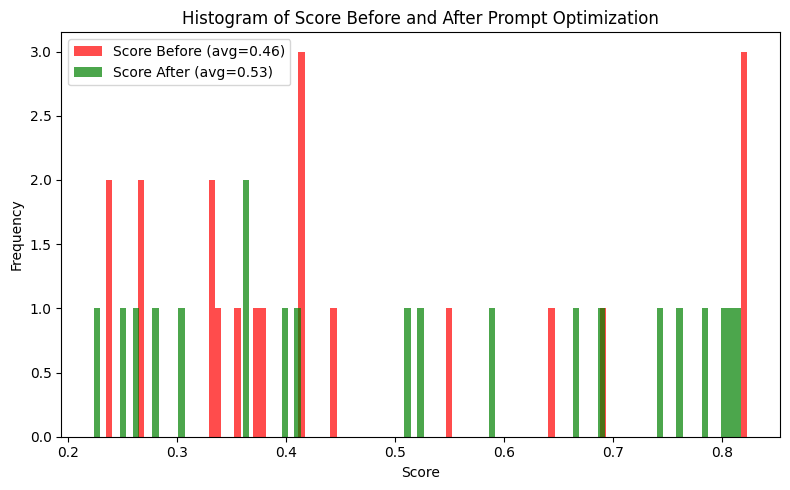

In [29]:
import matplotlib.pyplot as plt

# Calculate means
mean_before = final_eval_df['score_before'].mean()
mean_after = final_eval_df['score_after'].mean()

plt.figure(figsize=(8, 5))
plt.hist(final_eval_df['score_before'], bins=100, alpha=0.7, label=f'Score Before (avg={mean_before:.2f})', color='red')
plt.hist(final_eval_df['score_after'], bins=100, alpha=0.7, label=f'Score After (avg={mean_after:.2f})', color='green')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Histogram of Score Before and After Prompt Optimization')
plt.legend()
plt.tight_layout()
plt.show()